<a href="https://colab.research.google.com/github/sabasimba200/Air-quality/blob/main/AirPollution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade geemap earthengine-api

In [2]:
import ee
import geemap
import xarray as xr

In [3]:
!pip install xee
import xee

In [4]:
ee.Authenticate()
ee.Initialize(project='ee-smukonza', opt_url='https://earthengine.googleapis.com')

In [5]:
map = geemap.Map(basemap = 'TERRAIN')
map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', transp…

In [6]:
roi = map.draw_last_feature.geometry()
roi

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Feature.geometry",
    "arguments": {
      "feature": {
        "functionInvocationValue": {
          "functionName": "Feature",
          "arguments": {
            "geometry": {
              "functionInvocationValue": {
                "functionName": "GeometryConstructors.Polygon",
                "arguments": {
                  "coordinates": {
                    "constantValue": [
                      [
                        [
                          119.498291,
                          21.688057
                        ],
                        [
                          119.498291,
                          25.572176
                        ],
                        [
                          122.969971,
                          25.572176
                        ],
                        [
                          122.969971,
                          21.688057
                        ],
                        [
                          119.498291,
                          21.688057
                        ]
                      ]
                    ]
                  },
                  "geodesic": {
                    "constantValue": false
                  }
                }
              }
            }
          }
        }
      }
    }
  }
})

In [8]:
nitrogen = (
    ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2")
    .filterDate('2018', '2025')
    .filterBounds(roi)
    .select(['NO2_column_number_density'], ['no2'])
)

nitrogen.first()

In [9]:
ds = xr.open_dataset(nitrogen, engine= 'ee', crs = 'EPSG:4326', scale = 0.1, geometry = roi)
ds

<xarray.Dataset> Size: 30MB
Dimensions:  (time: 5423, lon: 35, lat: 39)
Coordinates:
  * time     (time) datetime64[ns] 43kB 2018-07-11T05:22:40 ... 2024-12-30T05...
  * lon      (lon) float64 280B 119.5 119.6 119.7 119.8 ... 122.7 122.8 122.9
  * lat      (lat) float64 312B 21.74 21.84 21.94 22.04 ... 25.34 25.44 25.54
Data variables:
    no2      (time, lon, lat) float32 30MB ...
Attributes: (12/19)
    date_range:               [1531180800000, 1647907200000]
    description:              <h3 id="nrtil3_no2">NRTI/L3_NO2</h3><p>This dat...
    keywords:                 ['air_quality', 'copernicus', 'esa', 'eu', 'knm...
    period:                   0
    product_tags:             ['tropomi', 'no2', 'nitrogen_dioxide', 'polluti...
    provider:                 European Union/ESA/Copernicus
    ...                       ...
    visualization_0_bands:    tropospheric_NO2_column_number_density
    visualization_0_max:      0.0002
    visualization_0_min:      0.0
    visualization_0_name:     RGB
    visualization_0_palette:  black,blue,purple,cyan,green,yellow,red
    crs:                      EPSG:4326

In [10]:
annual = ds.resample(time='YE').mean('time')
annual

<xarray.Dataset> Size: 39kB
Dimensions:  (time: 7, lon: 35, lat: 39)
Coordinates:
  * time     (time) datetime64[ns] 56B 2018-12-31 2019-12-31 ... 2024-12-31
  * lon      (lon) float64 280B 119.5 119.6 119.7 119.8 ... 122.7 122.8 122.9
  * lat      (lat) float64 312B 21.74 21.84 21.94 22.04 ... 25.34 25.44 25.54
Data variables:
    no2      (time, lon, lat) float32 38kB 5.917e-05 6.1e-05 ... 6.088e-05
Attributes: (12/19)
    date_range:               [1531180800000, 1647907200000]
    description:              <h3 id="nrtil3_no2">NRTI/L3_NO2</h3><p>This dat...
    keywords:                 ['air_quality', 'copernicus', 'esa', 'eu', 'knm...
    period:                   0
    product_tags:             ['tropomi', 'no2', 'nitrogen_dioxide', 'polluti...
    provider:                 European Union/ESA/Copernicus
    ...                       ...
    visualization_0_bands:    tropospheric_NO2_column_number_density
    visualization_0_max:      0.0002
    visualization_0_min:      0.0
    visualization_0_name:     RGB
    visualization_0_palette:  black,blue,purple,cyan,green,yellow,red
    crs:                      EPSG:4326

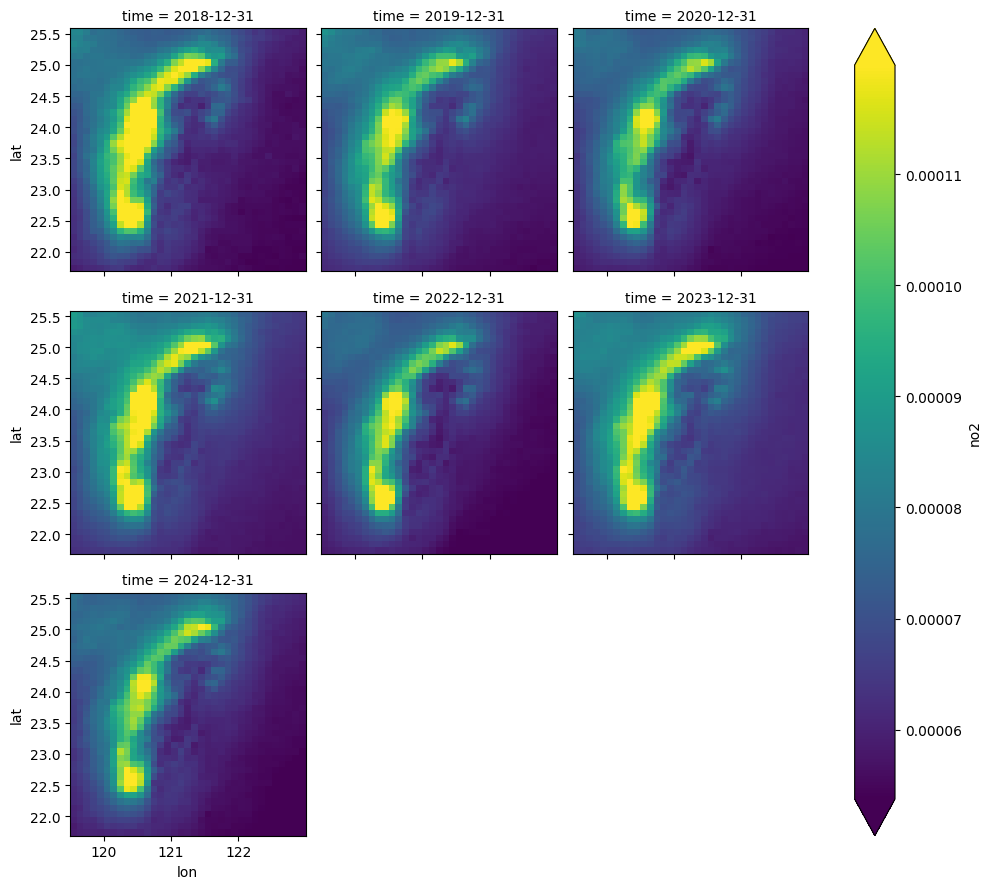

In [11]:
annual.no2.plot(
    x = 'lon',
    y = 'lat',
    col='time',
    col_wrap=3,
    robust=True
    )

In [12]:
annual_mean = annual.mean(dim = ['lon', 'lat'])
annual_mean

<xarray.Dataset> Size: 84B
Dimensions:  (time: 7)
Coordinates:
  * time     (time) datetime64[ns] 56B 2018-12-31 2019-12-31 ... 2024-12-31
Data variables:
    no2      (time) float32 28B 7.277e-05 7.209e-05 ... 7.61e-05 6.994e-05
Attributes: (12/19)
    date_range:               [1531180800000, 1647907200000]
    description:              <h3 id="nrtil3_no2">NRTI/L3_NO2</h3><p>This dat...
    keywords:                 ['air_quality', 'copernicus', 'esa', 'eu', 'knm...
    period:                   0
    product_tags:             ['tropomi', 'no2', 'nitrogen_dioxide', 'polluti...
    provider:                 European Union/ESA/Copernicus
    ...                       ...
    visualization_0_bands:    tropospheric_NO2_column_number_density
    visualization_0_max:      0.0002
    visualization_0_min:      0.0
    visualization_0_name:     RGB
    visualization_0_palette:  black,blue,purple,cyan,green,yellow,red
    crs:                      EPSG:4326

<Axes: xlabel='time'>

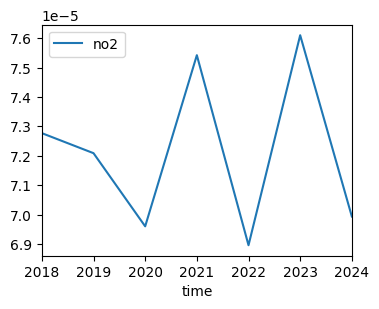

In [13]:
annual_mean.to_dataframe().plot(figsize=(4, 3))

In [14]:
annual_mean_df = annual_mean.to_dataframe()
annual_mean_df.reset_index(inplace=True)
annual_mean_df

,time,no2
0,2018-12-31,0.000073
1,2019-12-31,0.000072
2,2020-12-31,0.000070
3,2021-12-31,0.000075
4,2022-12-31,0.000069
5,2023-12-31,0.000076
6,2024-12-31,0.000070


In [15]:
annual_mean_df['anomaly'] = annual_mean_df['no2'] - annual_mean_df['no2'].mean()
annual_mean_df

,time,no2,anomaly
0,2018-12-31,0.000073,6.449482e-07
1,2019-12-31,0.000072,-3.632886e-08
2,2020-12-31,0.000070,-2.523935e-06
3,2021-12-31,0.000075,3.296343e-06
4,2022-12-31,0.000069,-3.166300e-06
5,2023-12-31,0.000076,3.975110e-06
6,2024-12-31,0.000070,-2.189838e-06


In [16]:
annual_mean_df = annual_mean_df.set_index("time")  # if there's a 'time' column


<Axes: xlabel='time'>

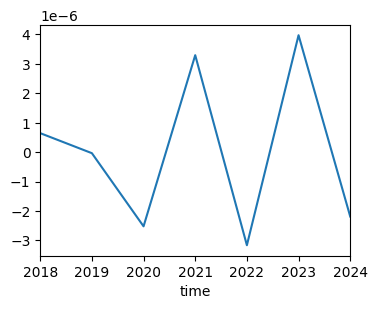

In [17]:
annual_mean_df.anomaly.plot(figsize=(4, 3))

<Axes: ylabel='time'>

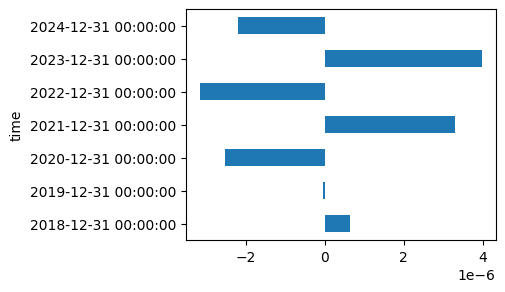

In [18]:
annual_mean_df.anomaly.plot.barh(figsize=(4, 3))